<span style="color:darkolivegreen;font-weight:800;font-size:32px">
    Building Agentic Apps: ArangoDB, NVIDIA cuGraph, and NetworkX Hackathon
</span>

<br>

<p align="center">
    <img src="https://arangodb.com/wp-content/uploads/2016/05/ArangoDB_logo_avocado_@1.png" style="height: 50px;">
    <img src="https://www.nvidia.com/content/dam/en-zz/Solutions/about-nvidia/logo-and-brand/02-nvidia-logo-color-grn-500x200-4c25-p@2x.png" style="height: 50px;">
    <img src="https://rapids.ai/images/RAPIDS-logo.png" style="height: 50px;">
    <img src="https://avatars.githubusercontent.com/u/388785?s=200&v=4" style="height: 50px;">
</p>

### Step 0: Package Installation & setup

In [1]:
# 1. Install nx-arangodb via pip
!pip install nx-arangodb

In [2]:
# 2. Check if you have an NVIDIA GPU
# Note: If this returns "command not found", then GPU-based algorithms via cuGraph are unavailable

!nvidia-smi
!nvcc --version

/bin/bash: line 1: nvidia-smi: command not found
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [3]:
# 3. Install nx-cugraph via pip
# Note: Only enable this installation if the step above is working!

!pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com # Requires CUDA-capable GPU

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [2]:
# 4. Install LangChain & LangGraph

!pip install --upgrade langchain langchain-community langchain-groq langgraph

  Using cached langchain_groq-0.2.4-py3-none-any.whl.metadata (3.0 kB)
  Using cached langchain_text_splitters-0.3.6-py3-none-any.whl.metadata (1.9 kB)
  Using cached langsmith-0.3.11-py3-none-any.whl.metadata (14 kB)
  Using cached pydantic-2.10.6-py3-none-any.whl.metadata (30 kB)
  Using cached SQLAlchemy-2.0.38-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.6 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached aiohttp-3.11.13-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached httpx_sse-0.4.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached groq-0.18.0-py3-none-any.whl.metadata (14 kB)
  Using cached langgraph_checkpoint-2.0.16-py3-none-any.whl.metadata (4.6 kB)
  Using cached langgraph_sdk-0.1.53-py3-none-any.whl

In [3]:
# 5. Import the required modules

import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

[18:22:31 +0530] [INFO]: NetworkX-cuGraph is unavailable: No module named 'cupy'.


In [4]:
# 6. Connect to the ArangoDB database
# TODO: Configure your credentials here!

db = ArangoClient(hosts="https://bad64b5a91c6.arangodb.cloud:8529").db(username="root", password="9u17nIbeG0yGs7fxBIMA", verify=True)

### Step 1: Choose & prepare your dataset for NetworkX

This section will provide a template for data transformation, including placeholders for loading CSV/JSON files, defining graph schemas, and preparing data for ingestion.

In [ ]:
# 2. Load the dataset into a CSV
# Reference: https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html#analysis
# Reference: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

fraud_ring_graph = pd.read_csv(
    "/content/fraud_23pct_synthetic_dataset_fixed.csv",
)

fraud_ring_graph

,Transaction_ID,Sender_account,Sender_age,Sender_is_elderly,Receiver_account,Receiver_age,Receiver_is_elderly,Amount,Date,Is_fraud,Sender_gender,Receiver_gender,Type_of_fraud,Method_of_contact,Loss,Time_of_day,Resolution_status
0,TXN-RPBLXMH9,267467544,39,0,457497252,45,0,337.98,2023-02-01,0,Female,Female,Legitimate,Direct,0.00,Evening,NaN
1,TXN-2CXN52T7,841081098,51,0,721081872,46,0,49.46,2023-12-04,0,Female,Female,Legitimate,Direct,0.00,Morning,NaN
2,TXN-GST7XUZQ,100585092,85,1,144171768,47,0,675.31,2023-03-25,0,Female,Male,Legitimate,Direct,0.00,Afternoon,NaN
3,TXN-693QNYBM,523559454,35,0,783269302,33,0,235.35,2023-12-08,0,Female,Male,Legitimate,Direct,0.00,Evening,NaN
4,TXN-IXUCE5YC,431747414,78,1,578280546,58,0,183.04,2023-10-27,0,Male,Female,Legitimate,Direct,0.00,Evening,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,TXN-VI3EYGZ8,576770529,82,1,614152854,49,0,93.67,2023-08-18,0,Male,Female,Legitimate,Direct,0.00,Morning,NaN
9996,TXN-N6TJ9XPF,154407200,82,1,699086909,25,0,40.76,2023-06-03,1,Male,Male,Romance Scam,Social Media,40.76,Evening,Unreported
9997,TXN-0B2YA51A,883403818,80,1,599020238,74,1,643.79,2023-03-09,0,Male,Female,Legitimate,Direct,0.00,Night,NaN
9998,TXN-MZ13E54I,805745462,20,0,151519597,57,0,175.84,2023-10-12,0,Female,Female,Legitimate,Direct,0.00,Night,NaN


### Step 2: Convert and Load Graph Data into NetworkX

This section will include placeholders for defining graph nodes, edges, and visualizing small test datasets before full ingestion.

Although we are creating a NetworkX Graph from a Pandas Edgelist in this example, there many other ways you can load data into NetworkX.

For more information about this, refer to the following documentation: https://networkx.org/documentation/stable/reference/convert.html

In [ ]:
G = nx.from_pandas_edgelist(
    fraud_ring_graph,
    source='Sender_account',
    target='Receiver_account',
    edge_attr=['Transaction_ID', 'Amount', 'Date', 'Is_fraud', 'Type_of_fraud', 'Loss'],
    create_using=nx.MultiDiGraph()
)

# Step 2: Add node attributes, including account number explicitly
node_attributes = {}
for _, row in fraud_ring_graph.iterrows():
    sender = row['Sender_account']
    receiver = row['Receiver_account']

    # Sender attributes
    if sender not in node_attributes:
        node_attributes[sender] = {
            'account': str(sender),  # Explicitly include account number
            'age': row['Sender_age'],
            'is_elderly': row['Sender_is_elderly'],
            'gender': row['Sender_gender']
        }

    # Receiver attributes
    if receiver not in node_attributes:
        node_attributes[receiver] = {
            'account': str(receiver),  # Explicitly include account number
            'age': row['Receiver_age'],
            'is_elderly': row['Receiver_is_elderly'],
            'gender': row['Receiver_gender']
        }

# Set node attributes
nx.set_node_attributes(G, node_attributes)

sample_node = list(G.nodes())[0]
print(f"Sample node ({sample_node}) attributes: {G.nodes[sample_node]}")

Sample node (267467544) attributes: {'account': '267467544', 'age': 39, 'is_elderly': 0, 'gender': 'Female'}


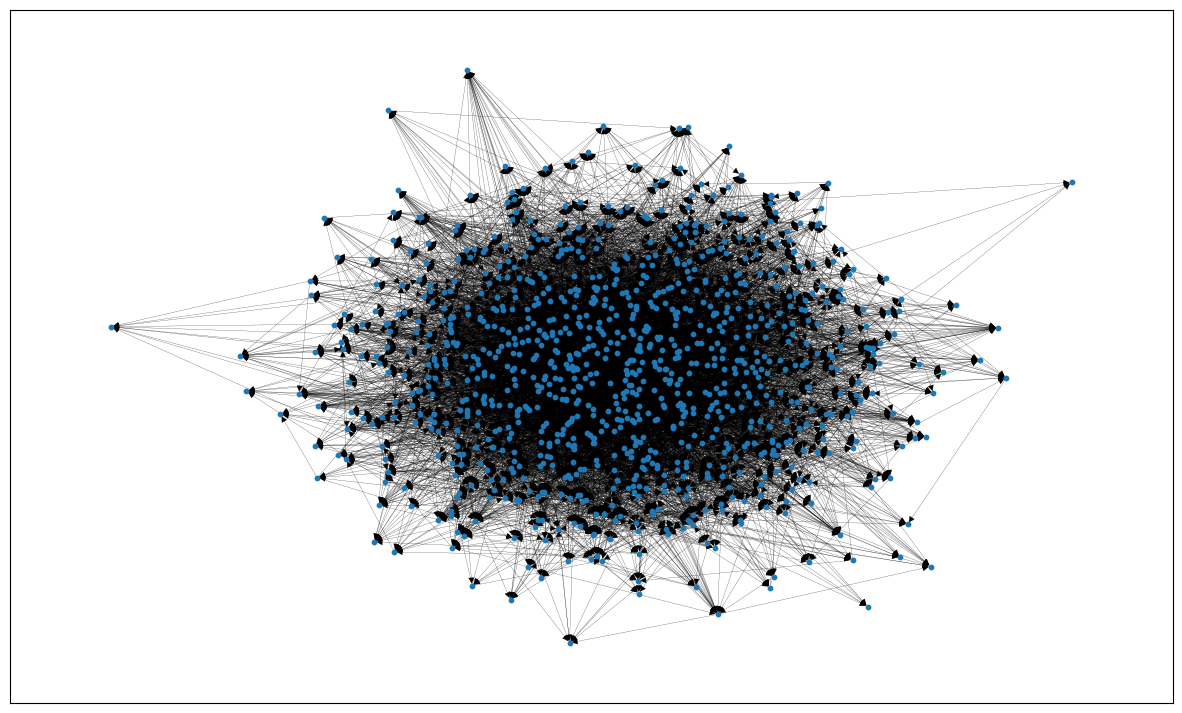

In [ ]:
# 3. Visualize the Graph

plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

### Step 3: Persist the Graph in ArangoDB

This section will include pre-written code templates for interacting with ArangoDB, making it easier for participants to insert and query their data.

For this new [nxadb.Graph()](https://nx-arangodb.readthedocs.io/en/latest/classes/graph.html) object, we will pass `name="Facebook"`, `db=db`, and `incoming_graph_data=G_nx`. This last parameter allows us to load the NetworkX Graph directly into ArangoDB:

In [5]:
# 1. Load the NetworkX Graph into ArangoDB

G_adb = nxadb.Graph(
    name="knowledge_graph",
    db=db,
    # incoming_graph_data=G,
    # write_batch_size=500,
    # overwrite_graph=True
)

print(G_adb)

[18:22:34 +0530] [INFO]: Graph 'knowledge_graph' exists.
[18:22:35 +0530] [INFO]: Default node type set to 'knowledge_graph_node'


Graph named 'knowledge_graph' with 1000 nodes and 10000 edges


In [ ]:
result = G_adb.query("""
  FOR node IN knowledge_graph_node
      SORT RAND()
      LIMIT 3
      RETURN node
""")
print(list(result))

[{'_key': '933', '_id': 'knowledge_graph_node/933', '_rev': '_jTQZSjS-_k', 'account': '917382757', 'age': 43, 'is_elderly': 0, 'gender': 'Male'}, {'_key': '872', '_id': 'knowledge_graph_node/872', '_rev': '_jTQZSjS--n', 'account': '708577342', 'age': 44, 'is_elderly': 0, 'gender': 'Male'}, {'_key': '597', '_id': 'knowledge_graph_node/597', '_rev': '_jTQZSjK-_d', 'account': '376442872', 'age': 52, 'is_elderly': 0, 'gender': 'Female'}]


In [ ]:
# 4. Query the Graph

# Sample 3 nodes
result = G_adb.query("""
    FOR node IN knowledge_graph_node
        SORT RAND()
        LIMIT 3
        RETURN node
""")

print(list(result))
print('-'*10)

# Sample 3 edges
result = G_adb.query("""
    FOR edge IN knowledge_graph_node_to_knowledge_graph_node
        SORT RAND()
        LIMIT 3
        RETURN edge
""")

print(list(result))
print('-'*10)

[{'_key': '229', '_id': 'knowledge_graph_node/229', '_rev': '_jTP0dGG-_O'}, {'_key': '416', '_id': 'knowledge_graph_node/416', '_rev': '_jTP0dGO--V'}, {'_key': '765', '_id': 'knowledge_graph_node/765', '_rev': '_jTP0dOy-AE'}]
----------
[{'_key': '7844', '_id': 'knowledge_graph_node_to_knowledge_graph_node/7844', '_from': 'knowledge_graph_node/726', '_to': 'knowledge_graph_node/424', '_rev': '_jTP0gAq--_', 'Transaction_ID': 'TXN-YN37MOVG', 'Amount': 149.39, 'Date': '2023-07-12', 'Is_fraud': 0, 'Type_of_fraud': 'Legitimate', 'Loss': 0}, {'_key': '5679', '_id': 'knowledge_graph_node_to_knowledge_graph_node/5679', '_from': 'knowledge_graph_node/496', '_to': 'knowledge_graph_node/67', '_rev': '_jTP0fXy-_A', 'Transaction_ID': 'TXN-Z9RTD6EN', 'Amount': 229.52, 'Date': '2023-08-25', 'Is_fraud': 1, 'Type_of_fraud': 'Other', 'Loss': 229.52}, {'_key': '5413', '_id': 'knowledge_graph_node_to_knowledge_graph_node/5413', '_from': 'knowledge_graph_node/475', '_to': 'knowledge_graph_node/65', '_rev':

In [ ]:
query = """
    LET fraud_receivers = (
        FOR edge IN knowledge_graph_node_to_knowledge_graph_node
            FILTER edge.Is_fraud == 1
            FOR sender IN knowledge_graph_node
                FILTER sender._id == edge._from AND sender.is_elderly == 1
            FOR receiver IN knowledge_graph_node
                FILTER receiver._id == edge._to AND receiver.is_elderly == 0
                RETURN DISTINCT receiver._key
    )
    FOR edge IN knowledge_graph_node_to_knowledge_graph_node
        FILTER edge._from IN (
            FOR fr IN fraud_receivers
                RETURN CONCAT('knowledge_graph_node/', fr)
        )
        FILTER edge._to IN (
            FOR fr IN fraud_receivers
                RETURN CONCAT('knowledge_graph_node/', fr)
        )
        RETURN {
            sender: DOCUMENT(edge._from)._key,
            receiver: DOCUMENT(edge._to)._key,
            transaction: edge
        }
"""

# Execute the query
result = G_adb.query(query)
connections = list(result)

In [ ]:
query = """LET fraud_receivers = (
    FOR edge IN knowledge_graph_node_to_knowledge_graph_node
        FILTER edge.Is_fraud == 1
        FOR sender IN knowledge_graph_node
            FILTER sender._id == edge._from AND sender.is_elderly == 1
        FOR receiver IN knowledge_graph_node
            FILTER receiver._id == edge._to
            RETURN DISTINCT receiver.account
)
RETURN fraud_receivers"""
result = G_adb.query(query)

<Cursor>

In [ ]:
result = G_adb.query("""
    FOR edge IN knowledge_graph_node_to_knowledge_graph_node
        FILTER edge.Is_fraud == 1
        RETURN edge
""")

# Print the results
fraudulent_edges = list(result)
print(f"Found {len(fraudulent_edges)} fraudulent transactions:")
for edge in fraudulent_edges:
    print(edge)

Found 2300 fraudulent transactions:
{'_key': '57', '_id': 'knowledge_graph_node_to_knowledge_graph_node/57', '_from': 'knowledge_graph_node/10', '_to': 'knowledge_graph_node/67', '_rev': '_jTQZS2i--B', 'Transaction_ID': 'TXN-9RK7D30M', 'Amount': 281.7, 'Date': '2023-06-26', 'Is_fraud': 1, 'Type_of_fraud': 'Other', 'Loss': 281.7}
{'_key': '58', '_id': 'knowledge_graph_node_to_knowledge_graph_node/58', '_from': 'knowledge_graph_node/10', '_to': 'knowledge_graph_node/67', '_rev': '_jTQZS2i--C', 'Transaction_ID': 'TXN-KT4781GX', 'Amount': 109.84, 'Date': '2023-02-17', 'Is_fraud': 1, 'Type_of_fraud': 'Other', 'Loss': 109.84}
{'_key': '61', '_id': 'knowledge_graph_node_to_knowledge_graph_node/61', '_from': 'knowledge_graph_node/10', '_to': 'knowledge_graph_node/302', '_rev': '_jTQZS2i--F', 'Transaction_ID': 'TXN-ZRDDN7P2', 'Amount': 118.19, 'Date': '2023-11-27', 'Is_fraud': 1, 'Type_of_fraud': 'Other', 'Loss': 118.19}
{'_key': '62', '_id': 'knowledge_graph_node_to_knowledge_graph_node/62', '

### Step 4: Build the Agentic App with LangChain & LangGraph

This section will provide pre-built agent templates, guiding participants on how to dynamically select AQL vs. NetworkX/cuGraph execution paths based on user input.

Reference:
- https://www.langchain.com/
- https://www.langchain.com/langgraph

In [6]:
# 1. Create the ArangoGraph LangChain wrapper
# Reference: https://api.python.langchain.com/en/latest/graphs/langchain_community.graphs.arangodb_graph.ArangoGraph.html

arango_graph = ArangoGraph(db)

In [7]:
import os

os.environ["GROQ_API_KEY"] = "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"
# os.environ["OPENAI_API_KEY"] = ""

In [8]:
# 4. Define the Text to AQL Tool
# from langchain_openai import ChatOpenAI

@tool
def text_to_aql_to_text(query: str):
    """
    This tool invokes the ArangoGraphQAChain to translate a natural language query into an optimized AQL query,
    execute the query on the graph database, and then convert the result back into natural language.

    Example queries:
      1. "Show details of account 12345."
      2. "Show all accounts directly linked to suspect account 12887419."
      3. "List all transactions made by this account 12389741."
    """
    # Create a low-temperature LLM instance for deterministic behavior
    llm = ChatGroq(temperature=0, model_name="llama-3.3-70b-versatile")
    # llm = ChatOpenAI(temperature=0.2, model_name="gpt-4o")

    # Create the chain from the LLM that converts natural language queries to AQL,
    # executes the AQL against the provided graph, and translates the result back to text.
    chain = ArangoGraphQAChain.from_llm(
        llm=llm,
        graph=arango_graph,
        verbose=True,
        allow_dangerous_requests=True
    )

    result = chain.invoke(query)
    return str(result["result"])


In [18]:
@tool
def text_to_nx_algorithm_to_text(query):
    """
    This tool invokes a NetworkX algorithm on the ArangoDB Graph.
    It accepts a natural language query, determines the best algorithm to execute,
    generates Python code to answer the query using the G_adb NetworkX graph, executes the code,
    and then synthesizes a concise natural language answer.

    IMPORTANT:
    - Use this tool only for queries that require graph analytics (e.g., centrality, shortest path, clustering).
    - For simple traversals solvable via AQL, do not use this tool.
    """
    import re
    from langchain import ChatOpenAI

    # Create an LLM instance for generating and refining Python code
    llm = ChatGroq(temperature=0.2, model_name="deepseek-r1-distill-qwen-32b")

    # Advanced prompt engineering: Provide full context of our fraud detection graph.
    advanced_prompt = f"""
You are a highly skilled Python code generator specializing in NetworkX graph analytics.
I have a NetworkX Graph called `G_adb` that represents a fraud detection network.
The node schema is:
{{
  "account": "<string>",
  "age": <int>,
  "is_elderly": <0 or 1>,
  "gender": "<Male/Female>"
}}
The edge schema is:
{{
  "Transaction_ID": "<string>",
  "Sender_account": "<string>",
  "Sender_age": <int>,
  "Sender_is_elderly": <0 or 1>,
  "Receiver_account": "<string>",
  "Receiver_age": <int>,
  "Receiver_is_elderly": <0 or 1>,
  "Amount": <float>,
  "Date": "<YYYY-MM-DD>",
  "Is_fraud": <0 or 1>,
  "Sender_gender": "<Male/Female>",
  "Receiver_gender": "<Male/Female>",
  "Type_of_fraud": "<string>",
  "Method_of_contact": "<string>",
  "Loss": <float>,
  "Time_of_day": "<string>",
  "Resolution_status": "<string>"
}}

I now have the following graph analysis query:
{query}

Your task is to generate executable Python code that uses the `G_adb` object to answer the query.
Instructions:
- Analyze the query and select the most appropriate NetworkX algorithm (e.g., shortest path, centrality, community detection).
- Include step-by-step reasoning as inline comments (do not print or return these comments).
- Ensure the final answer is stored in a variable called `FINAL_RESULT`, which must be a short, concise response.
- Only output the Python code (no extra explanations), ensuring it can be directly executed with `exec()`.
- Use only the standard libraries and assume NetworkX is installed.
Your code:
    """

    # Generate the Python code to perform the requested graph analysis
    text_to_nx = llm.invoke(advanced_prompt).content

    # Clean the generated code by removing markdown code fences if present
    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()

    print("1) Generated NetworkX code:")
    print('-'*10)
    print(text_to_nx_cleaned)
    print('-'*10)

    # Execute the generated code in a controlled environment
    print("\n2) Executing NetworkX code")
    global_vars = {"G_adb": G_adb, "nx": nx}
    local_vars = {}

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
    except Exception as e:
        error_message = f"EXEC ERROR: {e}"
        print(error_message)
        return error_message

    # Extract the FINAL_RESULT variable from the executed code
    try:
        FINAL_RESULT = local_vars["FINAL_RESULT"]
    except KeyError:
        error_message = "EXEC ERROR: FINAL_RESULT not defined in executed code."
        print(error_message)
        return error_message

    print('-'*10)
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    # Use the LLM to generate a concise natural language answer based on FINAL_RESULT and the original query
    refinement_prompt = f"""
I have a NetworkX Graph called `G_adb` with the fraud detection schema as previously described.
I executed code to answer the following query:
{query}

The code generated was:
---
{text_to_nx_cleaned}
---

The variable FINAL_RESULT holds the following value:
{FINAL_RESULT}

Based on the query and FINAL_RESULT, generate a short, clear, and concise natural language response to the query.
Your response:
    """
    nx_to_text = llm.invoke(refinement_prompt).content

    return nx_to_text

In [32]:
# 6. Create the Agentic Application

tools = [text_to_aql_to_text, text_to_nx_algorithm_to_text]

# import logging
# logging.basicConfig(level=logging.INFO)

def query_graph(query):
    # logging.info(f"Executing query: {query}")
    llm = ChatGroq(temperature=0.2, model_name="mixtral-8x7b-32768")
    app = create_react_agent(llm, tools)
    final_state = app.invoke({"messages": [{"role": "user", "content": query}]})
    return final_state["messages"][-1].content

In [ ]:
# 7. Experiment with example queries
# Note: Some may work, some may not!

# simple queries
query = "Show transactions flagged as fraudulent."
query = "Show all transactions above $100."
query = "Find all direct connections of account 500326438."
query = "Show details of account 287501362."
query = "Find all accounts linked to elderly individuals."

In [10]:
text_to_aql_to_text("Show all transactions above $100.")

/tmp/ipykernel_23620/2223380011.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  text_to_aql_to_text("Show all transactions above $100.")




> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH fraud-ring-graph_node_to_fraud-ring-graph_node, knowledge_graph_node_to_knowledge_graph_node
FOR edge IN fraud-ring-graph_node_to_fraud-ring-graph_node
    FILTER edge.Amount > 100
    RETURN edge

AQL Query Execution Error: 
syntax error, unexpected - operator near '-ring-graph_node_to_fraud-ring-g...' at position 2:11

AQL Query (2):
WITH fraud_ring_graph_node_to_fraud_ring_graph_node, knowledge_graph_node_to_knowledge_graph_node
FOR edge IN fraud_ring_graph_node_to_fraud_ring_graph_node
    FILTER edge.Amount > 100
    RETURN edge

AQL Query Execution Error: 
collection or view not found: fraud_ring_graph_node_to_fraud_ring_graph_node

AQL Query (3):
WITH fraud_ring_graph_node_to_fraud_ring_graph_node, knowledge_graph_node_to_knowledge_graph_node
FOR edge IN fraud_ring_graph_node_to_fraud_ring_graph_node
    FILTER edge.Amount > 100
    RETURN edge

AQL Query Execution Error: 
collection or view not found: fraud_ring_g

ValueError: 
                Maximum amount of AQL Query Generation attempts reached.
                Unable to execute the AQL Query due to the following error:
                collection or view not found: fraud_ring_graph_node_to_fraud_ring_graph_node
            

In [ ]:
# 8. (Optional) Set up UI via Gradio

!pip install gradio

In [ ]:
# import gradio as gr

# gr.Interface(fn=query_graph, inputs="text", outputs="text").launch(share=True)